In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import ensemblepy as ep
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

SAVE_FIGURES = False
THRESHOLD = 0.08

# Code for plotting the results

Actual results below.

In [2]:
def plot(data, ax, title='', limit=1.0, extras=('incoherence',), x='observations'):
    
    # pearson etc
    g = sns.lineplot(data=data[data['variable'].isin(['pearson', 'spearman', 'kendall'])],
            x=x, y='value', hue='variable', palette='flare', linestyle='dashed', ax=ax)
    
    # complexity
    g = sns.lineplot(data=data[data['variable'].isin(extras)],
            x=x, y='value', hue='variable', palette='crest', ax=ax)
    
    # settings reasonable height limits to give scale
    lims = ax.get_ylim()
    lower = min(lims[0], -0.01*limit)
    upper = lims[1] if lims[1] > limit else limit
    ax.set(ylim=(lower, upper))
    
    # adding a zero line for reference
    ax.axhline(y=0, color='grey', linestyle='solid')
    
    # adding a threshold
    ax.axhline(y=THRESHOLD, color='grey', linestyle='dotted')

    g.set(title=title, ylabel=None)
    
    # make sure legend is dashed
    leg_lines = ax.legend().get_lines()
    for ll in leg_lines[:3]:
        ll.set_linestyle("dashed")
    return g
    

def generate(y_func, obs_range, noise=None, trials=None):
    data, ecs = [], {}
    
    # generate data
    for i, o in enumerate(obs_range):
        nbsetup.cp(i)
        ecs[o] = []
        for t in range(trials):
            x = np.random.random(o)
            
            # generate y incl noise
            y = y_func(x, o)
            if noise is not None:
                y = y + np.random.normal(0, noise, len(y))
            
            # generate metrics
            ec = ep.Correlation(x, y)
            mt = ec.correlations()
            mt['observations'] = o
            mt['trial'] = t
            mt['noise'] = 0 if noise is None else noise
            data.append(mt)
            ecs[o].append(ec)
    
    nbsetup.cp('')
    return data, ecs

    
def analyse(y_func, noise=None, obs_range=ep.binint(200,1000,10,log=True), name=None, trials=30):
    data, ecs = generate(y_func, obs_range, noise, trials)
    
    # plots
    fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15,5))
    
    # plot scatters
    obs = obs_range[int(len(obs_range)/2)]
    ee = ecs[obs][0]
    f = sns.scatterplot(x=ee.x, y=ee.y, ax=axes[0])
    f.set_title("Sample at %s observations" % obs)
    
    # plot measures
    df = pd.DataFrame(data)
    cols = ['observations', 'noise']
    
    # Means
    plot(df.groupby(cols, as_index=False).mean().melt(id_vars=cols),
         axes[1], "Value of metrics")
    
    # Variance
    plot(df.groupby(cols, as_index=False).var().melt(id_vars=cols),
         axes[2], "Variance of metrics (%s trials)" % trials, 0.01, ('incoherence',))
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return ecs

# No correlations

In all cases when there is no correlation the metrics all tend to 0 and are certainly within the 0.1 bound.

We also see that ergodic complexity suffers from far less variance.

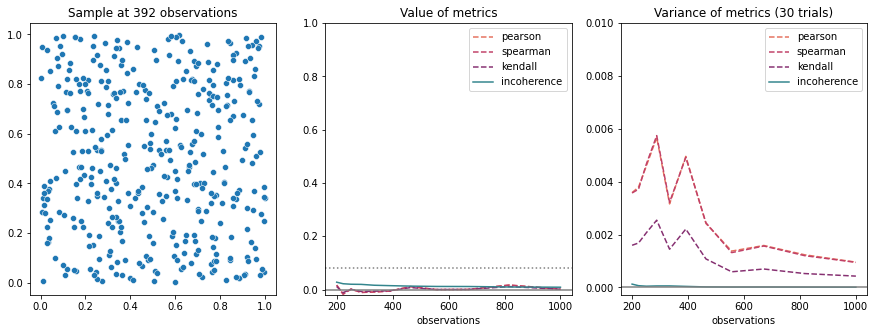

In [3]:
f = analyse(lambda x, o: np.random.random(o), name="random")

In [ ]:
f = analyse(lambda x, o: np.ones(o), noise=0.001, name="flat")

In [ ]:
f = analyse(lambda x, o: np.ones(o), noise=0.8, name="flat-noisy")

# A simple linear correlation

Now we start to see the metrics all shoot up high.

In [ ]:
f = analyse(lambda x,o: x, name="linear")

# Noise

However, as we introduce noise into the system the PearsonR and SpearmanR metrics perform better.

5


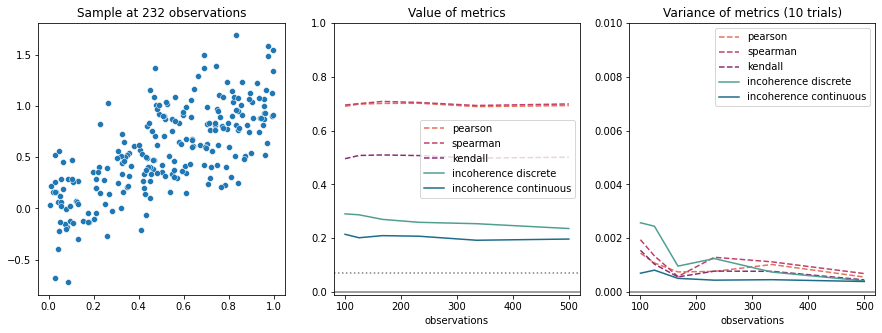

In [41]:
f = analyse(lambda x,o: x, noise=0.3, name="linear-noisy")

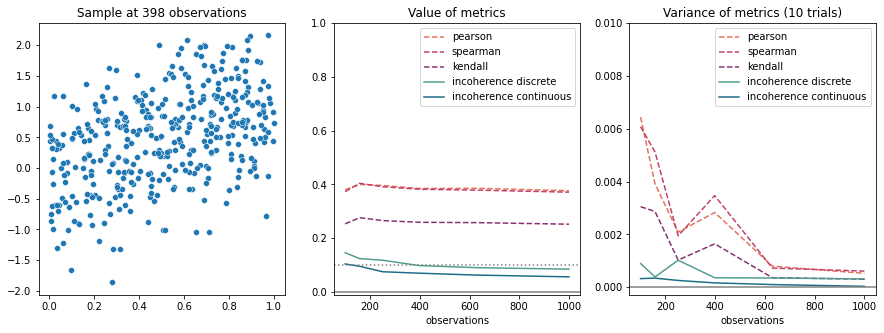

In [83]:
f = analyse((lambda x,o: x), noise=0.7, name="linear-very-very-noisy")

# Reverse

When the correlation is negative complexity picks this up, but does not reflect that the relationship is reversed. This is a feature which is utilised in it's power later.

Here the complexity metric does not give you an accurate measure of the correlation. Instead it's a compliment to encourage you to review the data in more detail and used as a compliment to PearsonR etc.

5


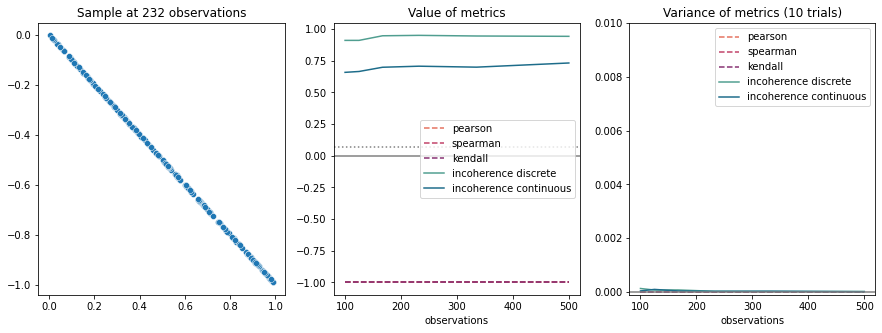

In [43]:
f = analyse(lambda x, o: -x, name="reverse-linear")

5


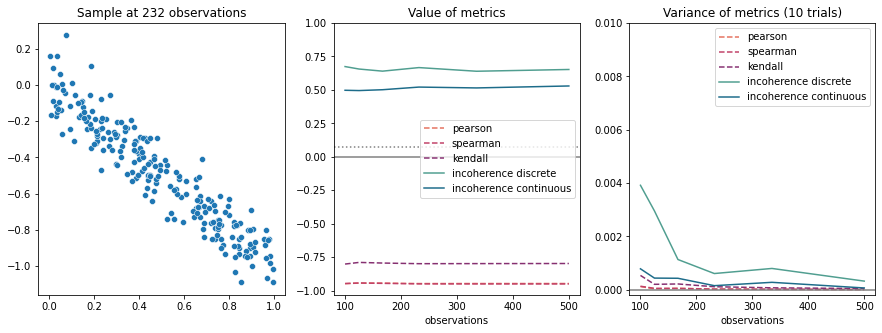

In [44]:
f = analyse(lambda x, o: -x, name="reverse-linear-noisy", noise=0.1)

# More exotic shapes

5


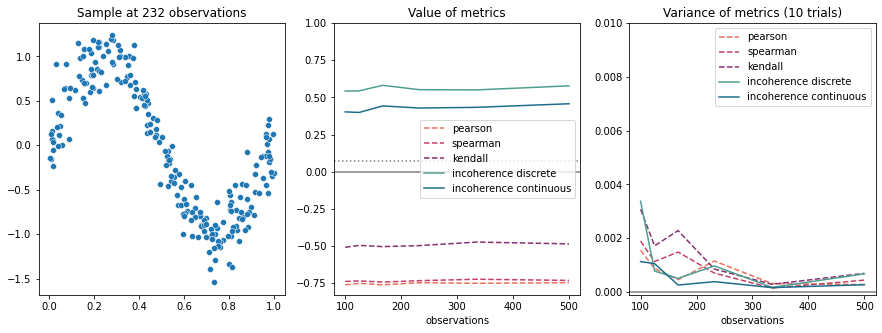

In [45]:
f = analyse(lambda x,o: np.sin(x*np.pi*2), noise=0.2, name="sin2pi")

5


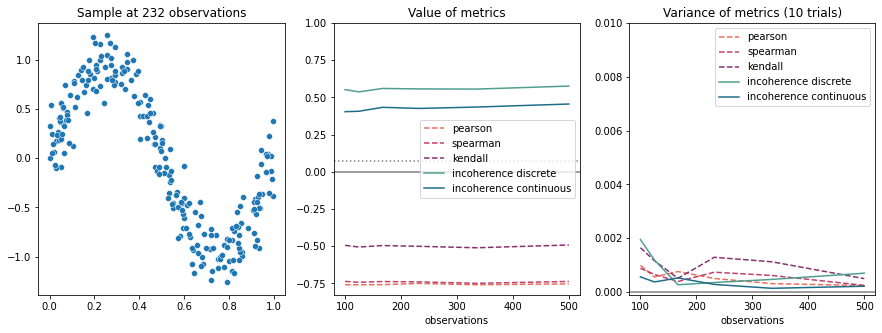

In [46]:
f = analyse(lambda x,o: np.sin(x*np.pi*2), noise=0.2, name="sin2pi")

5


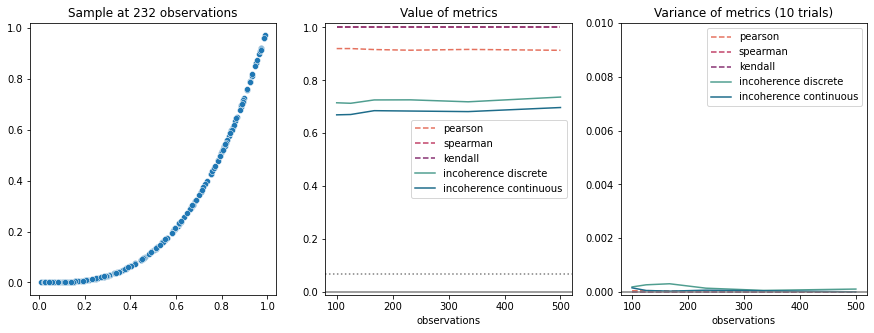

In [47]:
f = analyse(lambda x,o: x**3, name="power")

# Where incoherence is uniquely placed

In the following examples we see the ergodic complexity measure finding an interesting relationship between the data where the other metrics fail.

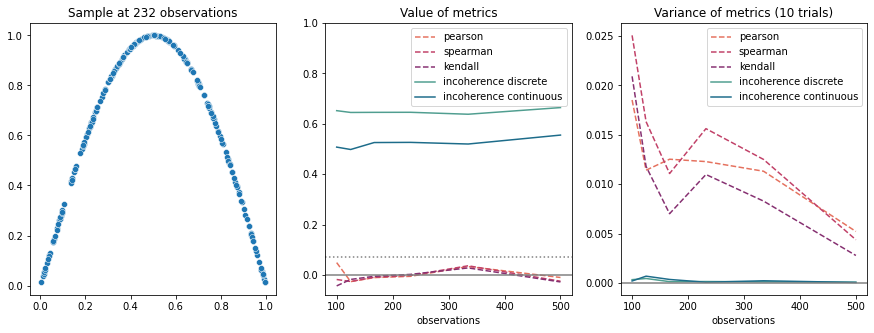

In [49]:
f = analyse(lambda x,o: np.sin(x*np.pi), name="sin-pi")

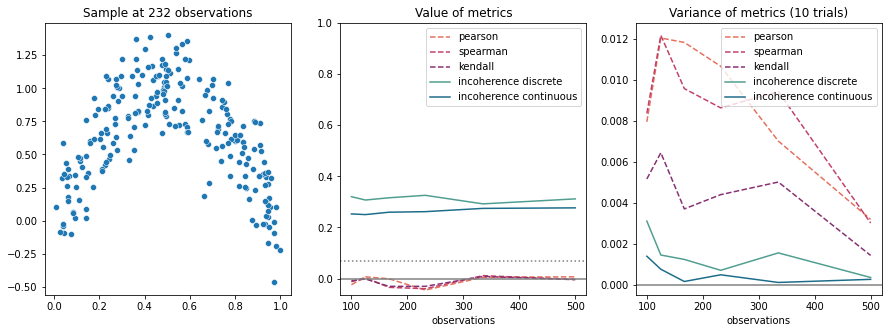

In [51]:
f = analyse(lambda x,o: np.sin(x*np.pi), name="sin-pi-noisy", noise=0.2)

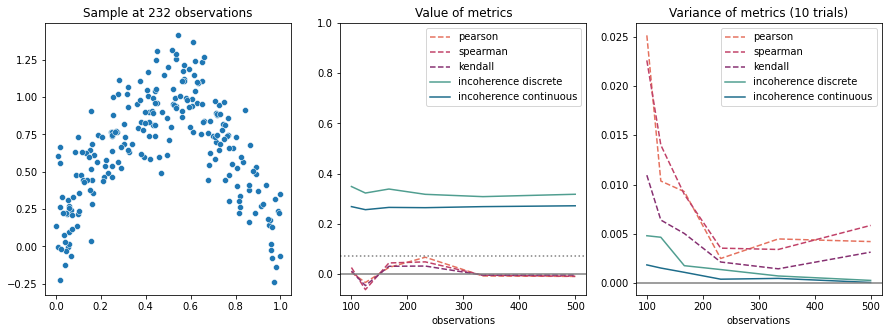

In [52]:
f = analyse(lambda x,o: np.sin(x*np.pi), name="sin-pi-noisy", noise=0.2)

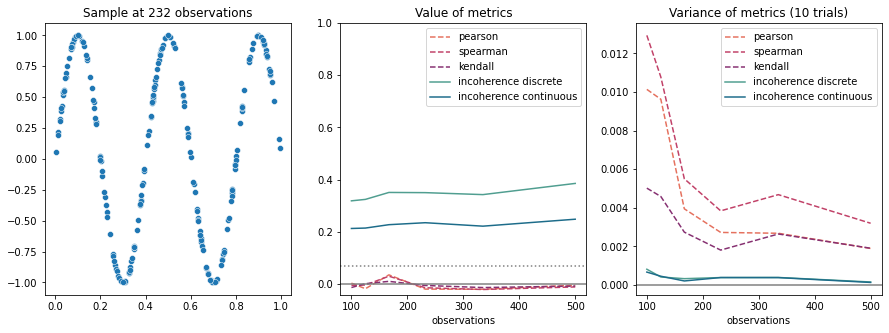

In [53]:
f = analyse(lambda x,o: np.sin(5*x*np.pi), name="sin5pi")

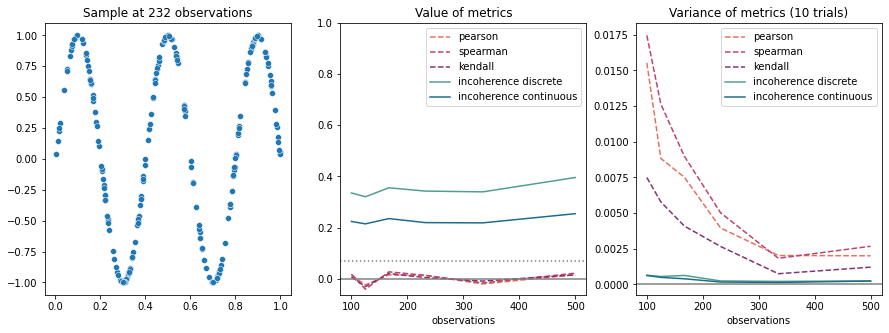

In [54]:
f = analyse(lambda x,o: np.sin(5*x*np.pi), name="sin5pi")

It's worth noting the level of noise impacts the absolute level of the ergodic complexity at the same rate irrelavent of relationship or shape of data (e.g. linear as above or sin as below).

# Specificly shaped models

In [92]:
try:
    funky = pd.read_csv("https://raw.githubusercontent.com/perlatex/R_for_Data_Science/master/demo_data/datasaurus.csv")
except:
    funky = pd.read_csv("../../datasets/datasaurus.csv")

Baselining with 142 (the rough number of observations in each shape in the dataset) random observations. Shows that ergodic complexity does better at saying there's no relationship.

In [93]:
def singular(x, y, name=None):
    ec = ep.Correlation(x, y)
    
    # plot the data raw
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(6,3))
    sns.scatterplot(x=x, y=y, ax=axes[0])
    
    # plot the lines in the same format
    df = pd.DataFrame([ec.correlations(), ec.correlations()])
    display(df)
    df['observations']=[0,1]
    g = plot(df.melt(id_vars=['observations']), axes[1])
    g.set(xlabel='Single %s point observation' % len(y), xticks=[])
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return ec

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.095855,0.256477,-0.098491,0.243566,-0.065428,0.247989,0.034681
1,-0.095855,0.256477,-0.098491,0.243566,-0.065428,0.247989,0.034681


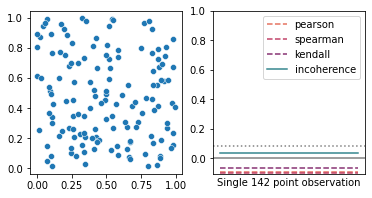

In [94]:
f = singular(np.random.random(142), np.random.random(142), name="single-random")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.064472,0.445897,-0.065109,0.441405,-0.048313,0.396138,0.164253
1,-0.064472,0.445897,-0.065109,0.441405,-0.048313,0.396138,0.164253


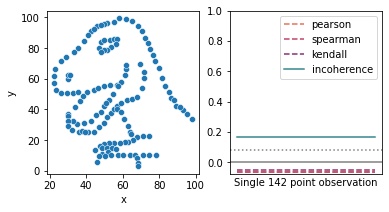

In [102]:
df = funky.loc[funky.dataset == 'dino']
f = singular(df['x'], df['y'], name="single-dino")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.062961,0.456649,-0.051445,0.543174,-0.032464,0.5665,0.408562
1,-0.062961,0.456649,-0.051445,0.543174,-0.032464,0.5665,0.408562


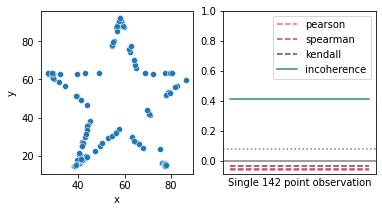

In [103]:
df = funky.loc[funky.dataset == 'star'].reset_index()
f = singular(df['x'], df['y'], name="single-star")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.065583,0.438078,-0.020535,0.808344,-0.026071,0.645276,0.410446
1,-0.065583,0.438078,-0.020535,0.808344,-0.026071,0.645276,0.410446


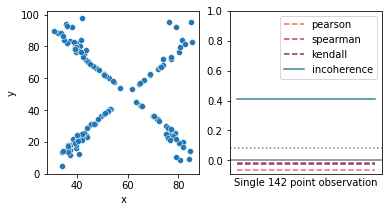

In [104]:
df = funky.loc[funky.dataset == 'x_shape'].reset_index()
f = singular(df['x'], df['y'], name="single-x")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.064128,0.448329,-0.0573,0.498197,-0.034862,0.538196,0.086816
1,-0.064128,0.448329,-0.0573,0.498197,-0.034862,0.538196,0.086816


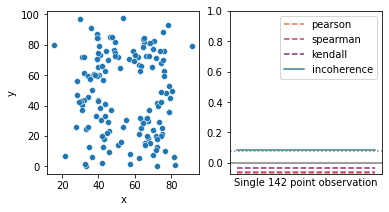

In [105]:
df = funky.loc[funky.dataset == 'away'].reset_index()
f = singular(df['x'], df['y'], name="single-away")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.068504,0.417906,-0.002869,0.972969,-0.00949,0.866933,0.059491
1,-0.068504,0.417906,-0.002869,0.972969,-0.00949,0.866933,0.059491


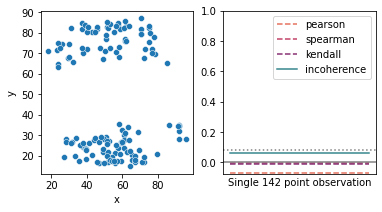

In [106]:
df = funky.loc[funky.dataset == 'high_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-high")

,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p,incoherence
0,-0.061715,0.465627,-0.051973,0.539037,-0.043252,0.445047,0.057888
1,-0.061715,0.465627,-0.051973,0.539037,-0.043252,0.445047,0.057888


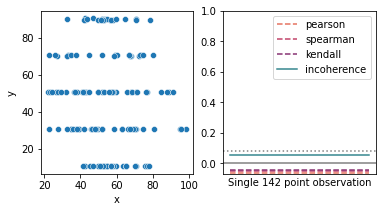

In [107]:
df = funky.loc[funky.dataset == 'h_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-h")

# Noise

In [ ]:
def noise_analyse(y_func, noises, obs=500, trials=100, name=''):
    # generate
    data = []
    obs_range = [obs,]
    for noise in noises:
        dd, ecs = generate(y_func, obs_range, noise=noise, trials=trials)
        data += dd
    
    # add ergodic complexity metric distance
    df = pd.DataFrame(data)
    df['distance'] = df['complexity']**0.5
    
    # plot
    fig, axes = plt.subplots(1, 1, figsize=(5,5))
    mdf = df.groupby('noise', as_index=False).mean().melt(id_vars=['noise', 'observations', 'trial'])
    plot(mdf, ax=axes, title=name, limit=1.0, extras=('complexity','distance'), x='noise')
    
    if SAVE_FIGURES:
        fig.savefig('figures/noise-%s.eps' % name)
    
    return df


In [ ]:
results = {}
noises = np.linspace(0.01, 1.5, 20)

In [ ]:
results['linear'] = noise_analyse(lambda x,o: x, noises, name='Linear')

In [ ]:
# sin distribution
results['sin'] = noise_analyse(lambda x,o: np.sin(x*np.pi), noises, name='Sin')

In [ ]:
# random noise distribution
results['random'] = noise_analyse(lambda x,o: np.random.random(size=o), noises, name='Random')

In [ ]:
# no relationship normal distribution
results['normal'] = noise_analyse(lambda x,o: np.random.normal(1,0.1,size=o), noises, name='Guassian')

In [ ]:
def plot_combined(res):
    for k,v in res.items():
        v['distribution'] = k

    combined = pd.concat(results.values())
    id_vars = ['noise', 'distribution']
    cdf = combined.groupby(id_vars, as_index=False).mean().melt(id_vars=id_vars)
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    
    # complexity
    g = sns.lineplot(data=cdf[cdf['variable'].isin(['complexity'])], x='noise', y='value', hue='distribution', ax=axes[0])
    g.set(title='Ergodic complex')
    axes[0].axhline(y=0.07, color='grey', linestyle='dashed')
    axes[0].axhline(y=0, color='lightgrey', linestyle='dotted')

    # distance
    g = sns.lineplot(data=cdf[cdf['variable'].isin(['distance'])], x='noise', y='value', hue='distribution', ax=axes[1])
    g.set(title='Ergodic distance')
    axes[1].axhline(y=0.07**0.5, color='grey', linestyle='dashed')
    axes[1].axhline(y=0, color='lightgrey', linestyle='dotted')
    
    # pearson
    g = sns.lineplot(data=cdf[cdf['variable'].isin(['pearson'])], x='noise', y='value', hue='distribution', ax=axes[2])
    g.set(title='Pearson')
    axes[2].axhline(y=0, color='lightgrey', linestyle='dotted')
    
    if SAVE_FIGURES:
        fig.savefig('figures/noise-distributions.eps')


In [ ]:
plot_combined(results)